In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import os
import zipfile
from google.colab import files

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure the API key

# Download the dataset to the content/ folder
dataset_name = "masoudnickparvar/brain-tumor-mri-dataset"
download_path = "/content"
print(f"Downloading dataset: {dataset_name} ...")
!kaggle datasets download -d {dataset_name} -p {download_path} --quiet

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [2]:
with zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset downloaded and extracted successfully in /content.")

Dataset downloaded and extracted successfully in /content.


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


# **Load Data**


In [4]:
Train_df = 'Training'

filepaths = []
labels = []
folds = os.listdir(Train_df)
for fold in folds:
    FoldPath = os.path.join(Train_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)

100%|██████████| 1339/1339 [00:00<00:00, 509172.53it/s]


In [5]:
print(len(filepaths))
print(len(labels))


5712
5712


In [6]:
print(labels[-1])


meningioma


In [7]:
print(np.unique(labels))

['glioma' 'meningioma' 'notumor' 'pituitary']


In [8]:
df_train = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)

In [9]:
df_train.head()

,filepath,label
0,Training/notumor/Tr-no_0714.jpg,notumor
1,Training/notumor/Tr-no_0161.jpg,notumor
2,Training/notumor/Tr-no_0627.jpg,notumor
3,Training/notumor/Tr-no_1190.jpg,notumor
4,Training/notumor/Tr-no_0487.jpg,notumor


In [10]:
color = ['#9AA6B2','#BCCCDC','#D9EAFD','#F8FAFC']

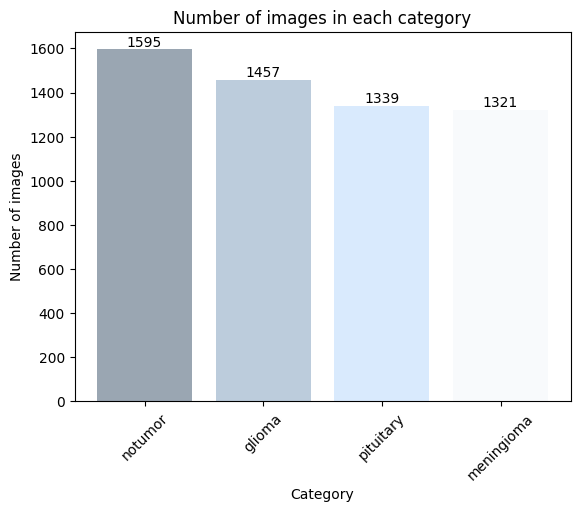

In [11]:

fig, ax = plt.subplots()
bars = ax.bar(df_train['label'].unique(), df_train['label'].value_counts(),color=color)
ax.bar_label(bars)
plt.title('Number of images in each category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

plt.show()


In [12]:
df_train.sample(5)

,filepath,label
3702,Training/pituitary/Tr-pi_0716.jpg,pituitary
3993,Training/pituitary/Tr-pi_1322.jpg,pituitary
719,Training/notumor/Tr-no_1026.jpg,notumor
3333,Training/pituitary/Tr-pi_0663.jpg,pituitary
1571,Training/notumor/Tr-no_0377.jpg,notumor


In [13]:
Test_df = 'Testing'

filepaths = []
labels = []
folds = os.listdir(Test_df)
for fold in folds:
    FoldPath = os.path.join(Test_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)

100%|██████████| 306/306 [00:00<00:00, 459526.32it/s]


In [14]:
print(len(filepaths))
print(len(labels))


1311
1311


In [15]:
print(np.unique(labels))

['glioma' 'meningioma' 'notumor' 'pituitary']


In [16]:
 df_test = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)

In [17]:
df_test.head()

,filepath,label
0,Testing/notumor/Te-no_0079.jpg,notumor
1,Testing/notumor/Te-no_0300.jpg,notumor
2,Testing/notumor/Te-no_0202.jpg,notumor
3,Testing/notumor/Te-no_0194.jpg,notumor
4,Testing/notumor/Te-no_0213.jpg,notumor


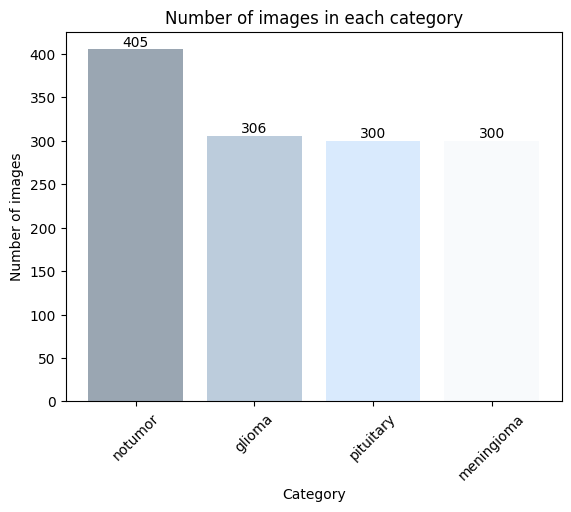

In [18]:

fig, ax = plt.subplots()
bars = ax.bar(df_test['label'].unique(), df_test['label'].value_counts(),color=color)
ax.bar_label(bars)
plt.title('Number of images in each category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

plt.show()


# **Split data into train, test, valid**

In [19]:
valid_ts, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [20]:
tr_gen = ImageDataGenerator(rescale=1/255)
ts_gen = ImageDataGenerator(rescale=1/255)
batchsize = 32
img_size = (224,224)

In [21]:
gen_train = tr_gen.flow_from_dataframe(df_train, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=True,color_mode='rgb')
gen_valid = ts_gen.flow_from_dataframe(valid_ts, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=True,color_mode='rgb')
gen_test = ts_gen.flow_from_dataframe(df_test, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=False ,color_mode='rgb')

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [22]:
class_dict = gen_train.class_indices


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import pickle
import tensorflow as tf

# Load the model from pickle file
model_path = "/content/drive/MyDrive/brain_tumor_model.pkl"
with open(model_path, 'rb') as file:
    model = pickle.load(file)

# Check the model architecture
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 236, 236, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 118, 118, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 118, 118, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 114, 114, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 57, 57, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 57, 57, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 53, 53, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       5,537,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 256)                 │           1,0

 Total params: 17,521,934 (66.84 MB)

 Trainable params: 5,840,196 (22.28 MB)

 Non-trainable params: 1,344 (5.25 KB)

 Optimizer params: 11,680,394 (44.56 MB)

In [25]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the pickled model (trained on 240x240 images)
model_path = "/content/drive/MyDrive/brain_tumor_model.pkl"
with open(model_path, 'rb') as file:
    model = pickle.load(file)

# Function to preprocess image for CNN model
def preprocess_image(image_path, img_size=(240, 240)):
    img = image.load_img(image_path, target_size=img_size)
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array

# Predict function (no feature extraction needed)
def predict_image(image_path, model):
    img_array = preprocess_image(image_path)  # Get preprocessed image
    prediction = model.predict(img_array)  # Predict using CNN model
    predicted_class = np.argmax(prediction)  # Get class index

    # Class labels
    class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    return 'no' if class_labels[predicted_class] == 'no_tumor' else 'yes'

# Run prediction
image_path = "/content/Testing/pituitary/Te-piTr_0002.jpg"
prediction = predict_image(image_path, model)
print(f"Prediction for {image_path}: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction for /content/Testing/pituitary/Te-piTr_0002.jpg: yes


In [26]:
print(model.input_shape)

(None, 240, 240, 3)


In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import numpy as np
import pickle

# Load the model from .pkl file
model_path = "/content/drive/MyDrive/brain_tumor_model.pkl"
with open(model_path, 'rb') as file:
    model = pickle.load(file)

# Ensure the model is compiled before evaluation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Image data generator
data_gen = ImageDataGenerator(rescale=1./255)

# Load training set
gen_train = data_gen.flow_from_directory(
    "/content/Training",
    target_size=(240, 240),
    batch_size=32,
    class_mode="categorical"
)

# Load test set
gen_test = data_gen.flow_from_directory(
    "/content/Testing",
    target_size=(240, 240),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Evaluate on training set
train_loss, train_acc = model.evaluate(gen_train, steps=len(gen_train))
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

# Evaluate on test set
test_loss, test_acc = model.evaluate(gen_test, steps=len(gen_test))
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Predictions
y_pred = model.predict(gen_test, steps=len(gen_test))
y_true = gen_test.classes

# Classification Report
print(classification_report(y_true, np.argmax(y_pred, axis=1)))


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.9999 - loss: 0.0036
Train Loss: 0.0041, Train Accuracy: 0.9996
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9457 - loss: 0.2237
Test Loss: 0.1313, Test Accuracy: 0.9649
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       300
           1       0.93      0.92      0.93       306
           2       0.99      1.00      0.99       405
           3       0.97      1.00      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [32]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d52dc4bc34b67688ceccdd1c39c4a6f301d5a6b5e5ad480513980dfe44d49f1d
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
!pip install shap


14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

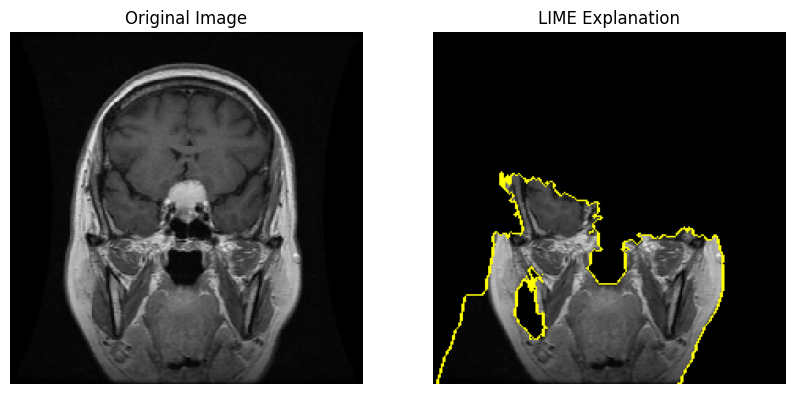

In [35]:
import tensorflow as tf
import numpy as np
import lime
from lime import lime_image
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Load a pre-trained model (Replace with your model)
model = tf.keras.applications.MobileNetV2(weights="imagenet")  # Example model

# Load and preprocess the image
def preprocess_image(image_path, img_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    return img_array, img

image_path = "/content/Testing/pituitary/Te-piTr_0002.jpg"
img_array, img = preprocess_image(image_path)

# Define LIME explainer
explainer = lime_image.LimeImageExplainer()

# Define a function for LIME to call the model
def model_predict(input_img):
    """Model prediction function for LIME"""
    return model.predict(input_img)

# Generate LIME explanation
explanation = explainer.explain_instance(
    img_array[0],  # Single image without batch dimension
    model_predict,
    top_labels=1,
    hide_color=0,
    num_samples=1000  # Reduce for faster computation
)

# Get mask and overlay on the image
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True
)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.axis("off")
plt.title("LIME Explanation")

plt.show()


In [ ]:
import tensorflow as tf
import numpy as np

def preprocess_image(img_path):
    """Load and preprocess an image for the model."""
    img_size = (224, 224)

    # Load image and resize
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)

    # Convert to array and normalize
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize

    return img_array, img


In [ ]:
img_array = preprocess_image("/content/Testing/glioma/Te-glTr_0000.jpg")[0]  # Ensure single image

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_7
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_7
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


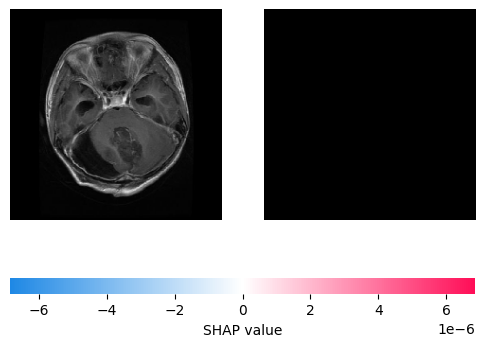

In [ ]:
import shap
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess image
img_array, img = preprocess_image("/content/Testing/glioma/Te-glTr_0000.jpg")

# Create a small background dataset (random images)
background = np.random.rand(10, 224, 224, 3)

# Use GradientExplainer instead of DeepExplainer
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values
shap_values = explainer.shap_values(img_array)

# Visualize SHAP explanation
shap.image_plot(shap_values, img_array)
